<a href="https://colab.research.google.com/github/yenlung/Deep-Learning-Basics/blob/master/colab03b%E4%BD%BF%E7%94%A8%E7%B4%85%E6%A8%93%E5%A4%A2%E7%94%9F%E6%88%90%E5%99%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 讀入使用套件

第一輪是讀進我們基本套件, 第二輪是 TensorFlow 用到的套件。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import pickle

from tensorflow.keras.models import load_model

### 2. 第一次執行要注意的事項

記得第一次使用前, 你需要把訓練好的紅樓夢 RNN model (`dream_rnn 資料夾`) 及 tokenizer (`dream_tokenizer2.pkl`), 放到你 Google Drive 的 Colab Notebook 存放區, 通常就是叫 Colab Notebooks 的資料夾。最簡單的方式也許是去[我的 GitHub 中](https://github.com/yenlung/Deep-Learning-Basics/tree/master/), 下載整個 repo, 再上傳需要的兩個部份。

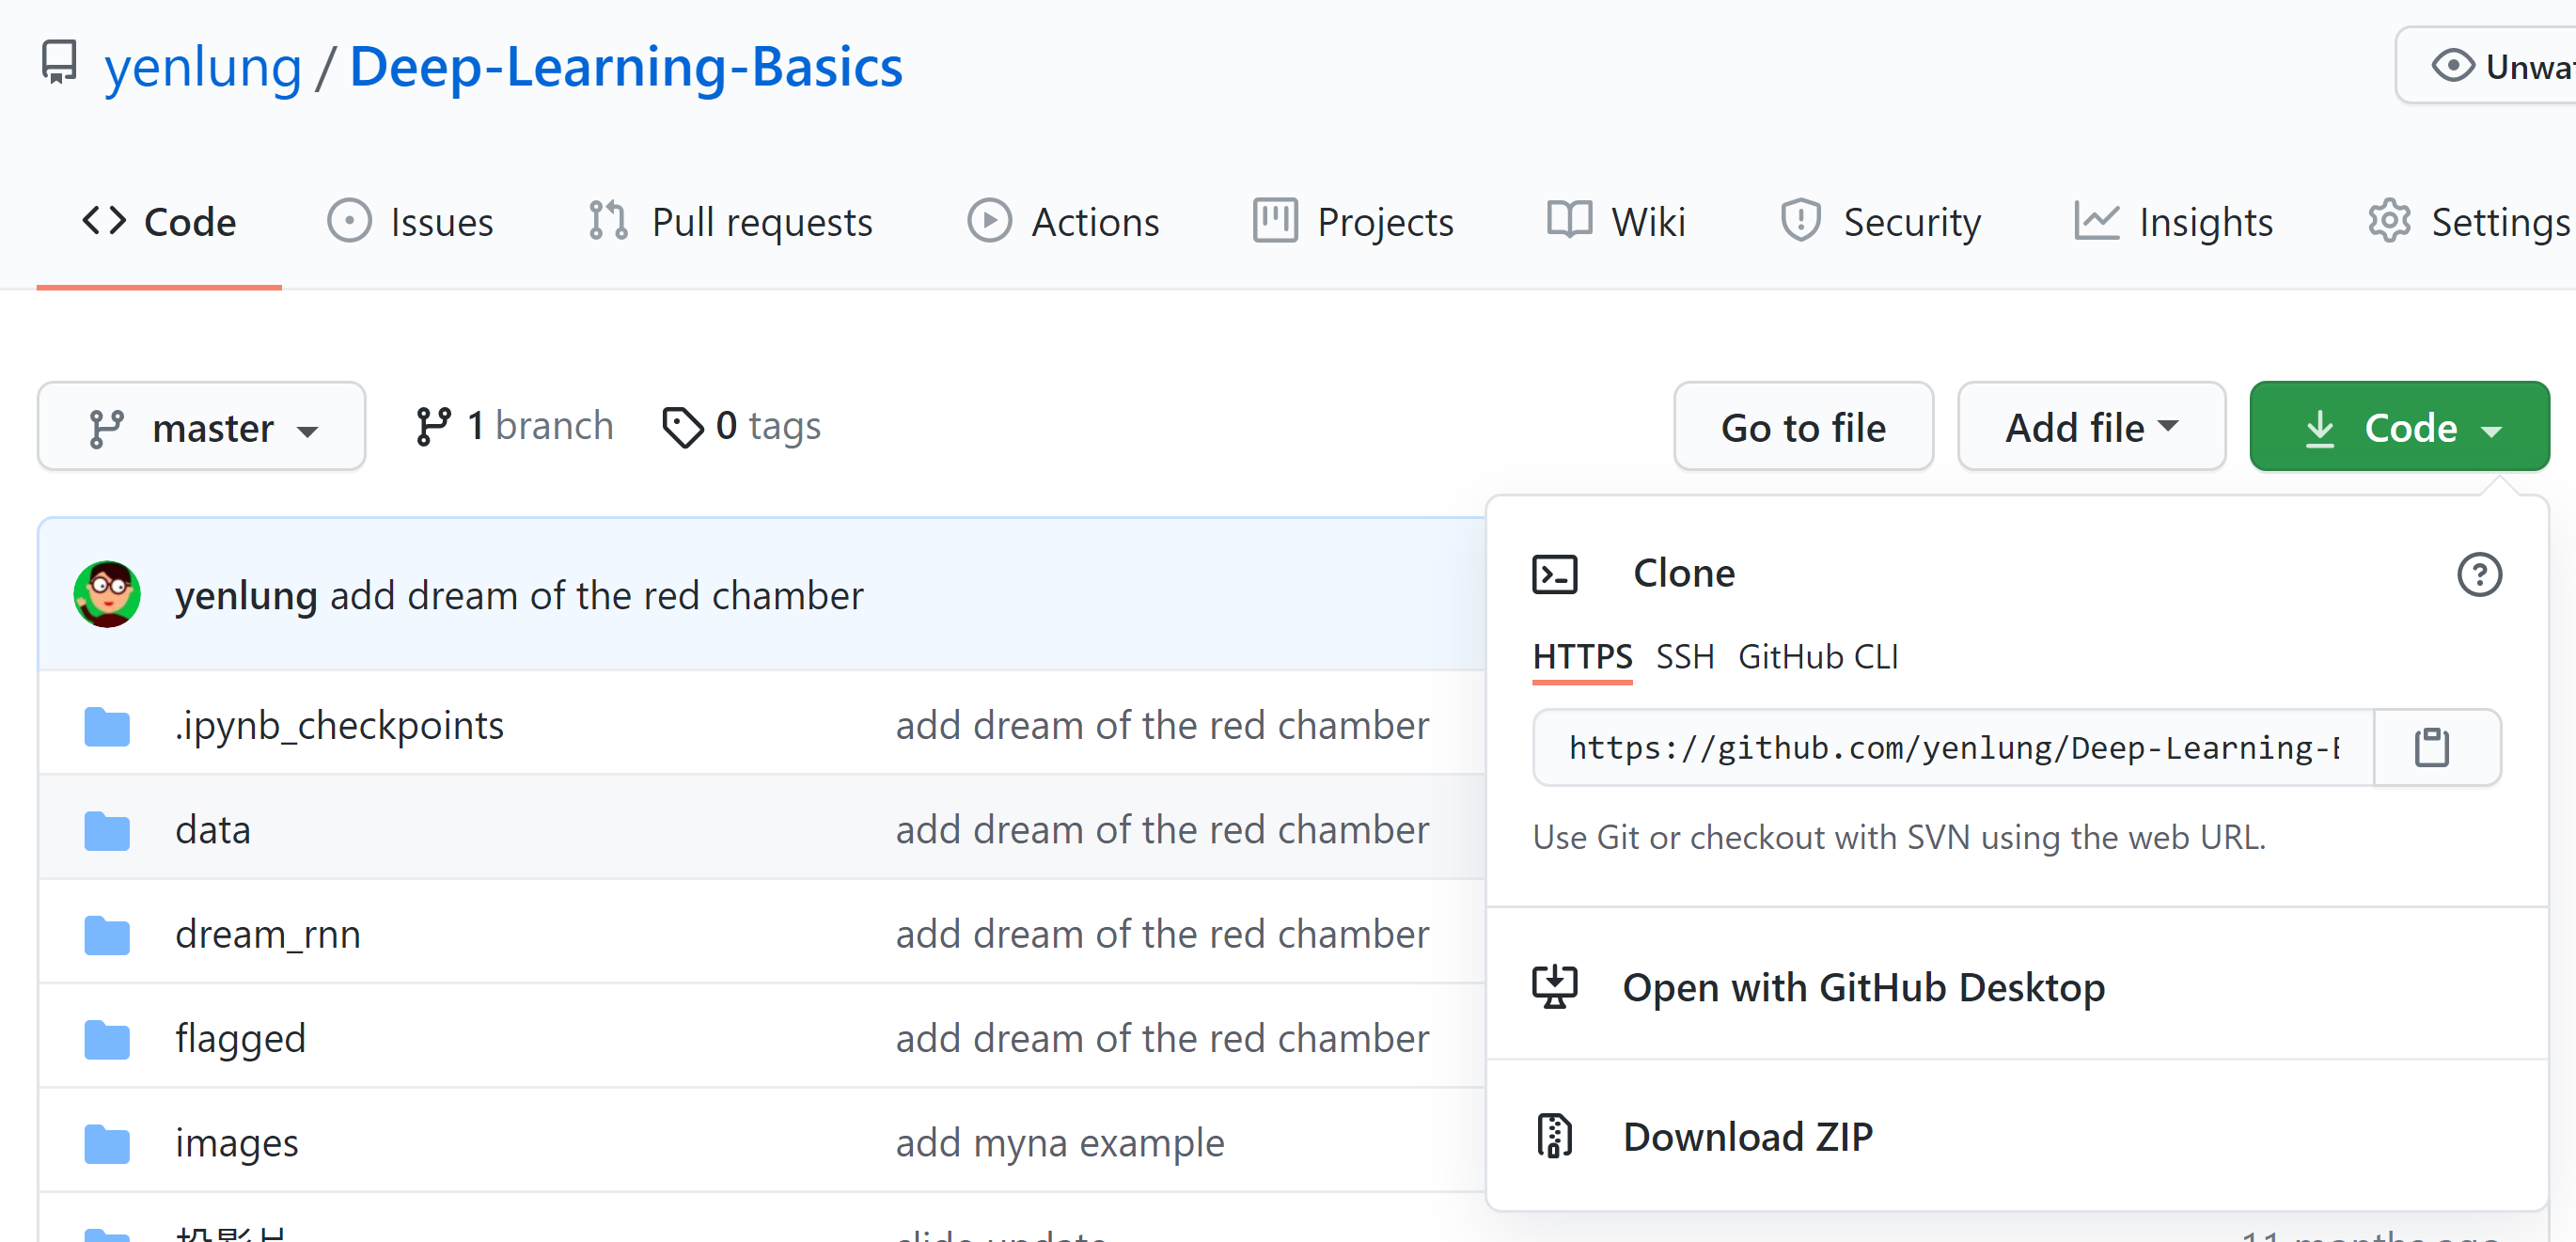

In [8]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


### 3. 讀入訓練好的 RNN 紅樓夢生成器

這裡是參考[《精通機器學習-使用 Scikit-Learn, Keras 與 TensorFlow》](https://www.books.com.tw/products/0010854043?sloc=main)這本書中莎士比亞生成器的部份寫成的。架構很簡單,就每輸入 100 個字, 預測下一個字是什麼。雙層 LSTM, 每層 128 個神經元。訓練 10 次, 在 1080Ti GPU 的電腦上大概花了 10 個小時。


In [11]:
model = load_model('dream_rnn')

In [13]:
f = open('dream_tokenizer2.pkl', 'rb')
tokenizer = pickle.load(f)
f.close()

### 4. 製造紅樓夢生成器

In [14]:
max_id = len(tokenizer.word_index)

In [15]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences([texts]))-1
    return tf.one_hot(X, max_id)

In [16]:
def next_char(texts, temperature=1):
    X_new = preprocess(texts)
    y_predict = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_predict) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [17]:
def complete_text(texts, n_chars=50, temperature=1):
    n_chars=int(n_chars)
    for _ in range(n_chars):
        texts = texts + next_char(texts[-100:], temperature)
    return texts

來測試一下。

In [18]:
complete_text("自孫悟空從石頭中蹦出來之後，", n_chars=300, temperature=0.2)

'自孫悟空從石頭中蹦出來之後，說道：「你們不知道，只是你們這個人，也不知道，只是你們的心腸兒，如今是了。」寶玉聽了，便說道：「你這個人也不用說，我是一句話說不出來，我也不用說。」說著，又聽見寶玉的話，心裡便說道：「我們不知道了，我是一個人，我們有一個人，你們不知道，我是一個人，也不敢說的。」王夫人道：「我也是這樣的。」邢夫人聽了，便說：「我們莊家人家，你們這樣的好處，我們莊家人家，不是有的。我們姑娘們也不用說，只要等我告訴你罷。」薛姨媽聽了，點頭嘆道：「我說是不該娶親，但只我想想著，她是不肯叫人家的人，你們這樣一辦，我也不用說，我是一種潑辣人，委委屈屈的上轎而去。」王夫人道：「我也不用說，只要等我們大太太作主。」王夫人道：'

### 5. 用 `gradio` 做成一個網路 app

In [20]:
!pip install gradio

     |████████████████████████████████| 2.5MB 8.5MB/s 
     |████████████████████████████████| 1.9MB 44.8MB/s 
     |████████████████████████████████| 215kB 41.3MB/s 
     |████████████████████████████████| 962kB 30.0MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
     |████████████████████████████████| 3.2MB 45.4MB/s 
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-cp37-none-any.whl size=3372 sha256=781ddcd115c03e6b911967bca6d0727e1ec06d25642f437dc9782367be856370
  Stored in directory: /root/.cache/pip/wheels/9f/fc/a7/ab5712c3ace9a8f97276465cc2937316ab8063c1fea488ea77
  Created wheel for ffmpy: filename=ffmpy-0.3.0-cp37-none-any.whl size=4710 sha256=f3516ef42ba18ed1e01ed5d828043202115df5535a28de99c55f05a58de92753
  Stored in directory: /root/.cache/pip/wheels/cc/ac/c4/bef572cb7e52bfca170046f567e64858632daf77e0f34e5a74
Successfully built flask-cachebuster ffmpy


In [21]:
import gradio as gr

In [22]:
iface = gr.Interface(
    fn=complete_text,
    inputs=[
        "text",
        gr.inputs.Slider(50, 200, 1, 50),
        gr.inputs.Slider(0.2, 2, 0.2, 1)],
    outputs="text",
    title="紅樓夢生成器",
    description="起個頭, 幫你完成一段紅樓夢。可以改變 temperature, 越小生出的字越固定, 越大越隨機。")
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://14532.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://14532.gradio.app')